# (Step 2) Data Preprocessing

## Always handle collinearity and multicollinearity


In [1]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Regression and Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Define functions

def generate_heatmap(X_input):
    corrmat = X_input.corr(method='spearman')
    top_corr_features = corrmat.index


    # Visualise a lower-triangle correlation heatmap
    mask_df = np.triu(np.ones(corrmat.shape)).astype(np.bool)
    plt.figure(figsize=(10,8))
    #plot heat map
    g=sns.heatmap(X_input[top_corr_features].corr(), 
                  mask = mask_df, 
                  vmin = -1,
                  vmax = 1,
                  annot=True,
                  cmap="RdBu")


train_dataset = pd.read_csv(("../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

## Construct a black-box model (Random Forests)

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

RandomForestClassifier(n_jobs=10, random_state=1234)

### Collinearity (Pairwise Correlation)

Collinearity is a phenomenon in which one metric can be linearly predicted by another metric. 
There are several correlation tests that can detect collinearity between metrics. For example, Pearson correlation test, Spearman correlation test, and Kendall Tau correlation test.
Below, we provide a tutorial for using and visualising Spearman correlation test.

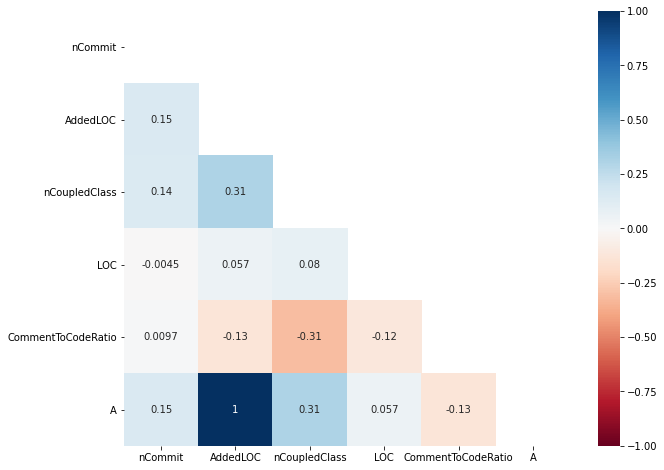

In [2]:
# Import for Correlation tests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Prepare a dataframe for collinearity simulation
X_Corr = X_train.copy()

# Simulate a collinearity situation of AddedLOC and A
X_Corr['A'] = [2 * x_i + random.random() for x_i in X_Corr['AddedLOC']]


# There are 3 options for the parameter setting of method as follows:
# pearson : standard correlation coefficient
# kendall : Kendall Tau correlation coefficient
# spearman : Spearman rank correlation
corrmat = X_Corr.corr(method='spearman')
top_corr_features = corrmat.index


# Visualise a lower-triangle correlation heatmap
mask_df = np.triu(np.ones(corrmat.shape)).astype(np.bool)
plt.figure(figsize=(10,8))
#plot heat map
g=sns.heatmap(X_Corr[top_corr_features].corr(), 
              mask = mask_df, 
              vmin = -1,
              vmax = 1,
              annot=True,
              cmap="RdBu")

### Multicollinearity

Multicollinearity is a phenomenon in which one metric can be linearly predicted by a combination of two or more metrics. 
Multicollinearity can be detected using Variance Inflation Factor (VIF) analysis {cite}`fox1992generalized`.
The idea behind variance inflation factor analysis is to construct an ordinary least square regression to predict a metric by using the other metrics in the dataset.
Having a model that is well fit indicates that the metric can be predicted by other metrics, linearly highly-correlated with other metrics.
There are 3 steps in variance inflation factor analysis.

*(Step 1) Construct a regression model for each metric.*
For each metric, we construct a model using the other metrics to predict that particular metric.

*(Step 2) Compute a VIF score for each metric.*
The VIF score for each metric is computed using the following formula: $\mathrm{VIF} = \frac{1}{1 - \mathrm{R}^2}$, where $\mathrm{R}^2$ is the explanatory power of the regression model from Step 1.
A high VIF score of a metric indicates that a given metric can be accurately predicted by the other metrics.
Thus, that given metric is considered redundant and should be removed from our model.

*(Step 3) Remove metrics with a VIF score that is higher than a given threshold.*
We remove metrics with a VIF score that is higher than a given threshold.
We use a VIF threshold of 5 to determine the magnitude of multi-collinearity, as it is suggested by Fox {cite}`fox2015applied`.
Then, we repeat the above three steps until the VIF scores of all remaining metrics are lower than the pre-defined threshold.

In [3]:
# Import for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Prepare a dataframe for VIF
X_VIF = add_constant(X_train)

# Simulate a multicollinearity situation of AddedLOC, A, and B
X_VIF['A'] = [2 * x_i + random.random() for x_i in X_VIF['AddedLOC']]
X_VIF['B'] = [3 * x_i + random.random() for x_i in X_VIF['AddedLOC']]

# Calculate VIF scores
vif_scores = pd.DataFrame([variance_inflation_factor(X_VIF.values, i) 
               for i in range(X_VIF.shape[1])], 
              index=X_VIF.columns)
# Prepare a final dataframe of VIF scores
vif_scores.reset_index(inplace = True)
vif_scores.columns = ['Feature', 'VIFscore']
vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
vif_scores = vif_scores.sort_values(by = ['VIFscore'], ascending = False)
vif_scores

,Feature,VIFscore
2,AddedLOC,3.363851e+06
7,B,2.421962e+06
6,A,1.078763e+06
3,nCoupledClass,1.220642e+00
5,CommentToCodeRatio,1.126280e+00
1,nCommit,1.044982e+00
4,LOC,1.019733e+00


In this example, we observe that LOC, A, and B are problematic with the VIF scores of above 5.
To mitigate multicollinearity, we need to exclude one metric with the highest VIF score, i.e., LOC.
We iteratively repeat the process as described above.

In [4]:
# Import for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import random

# Prepare a dataframe for VIF
X_VIF = add_constant(X_train)

# Simulate a multicollinearity situation of AddedLOC, A, and B
X_VIF['A'] = [2 * x_i + random.random() for x_i in X_VIF['AddedLOC']]
X_VIF['B'] = [3 * x_i + random.random() for x_i in X_VIF['AddedLOC']]


selected_features = X_VIF.columns

# Stepwise-VIF
print('Stepwise VIF START')
count = 1
while True:
    # Calculate VIF scores
    vif_scores = pd.DataFrame([variance_inflation_factor(X_VIF.values, i) 
                   for i in range(X_VIF.shape[1])], 
                  index=X_VIF.columns)
    # Prepare a final dataframe of VIF scores
    vif_scores.reset_index(inplace = True)
    vif_scores.columns = ['Feature', 'VIFscore']
    vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
    vif_scores.sort_values(by = ['VIFscore'], ascending = False, inplace = True)
    
    # Find features that have their VIF scores of above 5.0
    filtered_vif_scores = vif_scores[vif_scores['VIFscore'] >= 5.0]
    
    # Terminate when there is no features with the VIF scores of above 5.0
    if len(filtered_vif_scores) == 0:
        break
        
    # exclude the metric with the highest VIF score
    metric_to_exclude = list(filtered_vif_scores['Feature'].head(1))[0]
    
    
    print('Step', count,'- exclude', str(metric_to_exclude))
    count = count + 1
        
    selected_features = list(set(selected_features) - set([metric_to_exclude]))
    
    X_VIF = X_VIF.loc[:, selected_features]
print('The following features are selected according to Stepwise VIF with the VIF threshold value of 5:')
print(vif_scores)

Stepwise VIF START
Step 1 - exclude AddedLOC
Step 2 - exclude B
The following features are selected according to Stepwise VIF with the VIF threshold value of 5:
              Feature  VIFscore
4       nCoupledClass  1.220647
5                   A  1.122400
2  CommentToCodeRatio  1.120934
3             nCommit  1.039827
0                 LOC  1.017052


### Feature selection techniques often do not mitigate collinearity and multicollinearity!


Feature selection is a data preprocessing technique for selecting a
subset of the best software metrics prior to constructing a defect
model. There is a plethora of feature selection techniques that can be
applied {cite}`guyon2003introduction`, e.g., filter-based, wrapper-based, and
embedded-based families. 

#### Filter-based Family

Filter-based feature selection techniques search for the best subset of
metrics according to an evaluation criterion regardless of model
construction. Since constructing models is not required, the use of
filter-based feature selection techniques is considered low cost and
widely used.

**Chi-Squared-based feature selection** {cite}`mchugh2013chi` assesses the
importance of metrics with the $\chi^2$ statistic which is a
non-parametric statistical test of independence.


In [5]:
# Import for Chi-sqaured-based feature selection technique
from sklearn.feature_selection import SelectKBest, chi2

top_k = 3
chi2_fs = SelectKBest(chi2, k=top_k).fit(X_train, y_train)
dfscores = pd.DataFrame(chi2_fs.scores_)
dfcolumns = pd.DataFrame(features)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print('Top-k features (k ='+str(top_k)+') according to Chi-squared statistics are as follows:')
print(featureScores.nlargest(top_k,'Score')) 

Top-k features (k =3) according to Chi-squared statistics are as follows:
              Feature         Score
1            AddedLOC  26834.488115
2       nCoupledClass   1599.996258
4  CommentToCodeRatio     64.268658



#### Wrapper-based Family

Wrapper-based feature selection
techniques {cite}`john1994irrelevant`{cite}`kohavi1997wrappers` use classification
techniques to assess each subset of metrics and find the best subset of
metrics according to an evaluation criterion. Wrapper-based feature
selection is made up of three steps, which we described below.

*(Step 1) Generate a subset of metrics.* Since it is impossible to
evaluate all possible subsets of metrics, wrapper-based feature
selection often uses search techniques (e.g., best first, greedy hill
climbing) to generate candidate subsets of metrics for evaluation.

*(Step 2) Construct a classifier using a subset of metrics with a
predetermined classification technique.* Wrapper-based feature selection
constructs a classification model using a candidate subset of metrics
for a given classification technique (e.g., logistic regression and
random forest).

*(Step 3) Evaluate the classifier according to a given evaluation
criterion.* Once the classifier is constructed, wrapper-based feature
selection evaluates the classifier using a given evaluation criterion
(e.g., Akaike Information Criterion).

For each candidate subset of metrics, wrapper-based feature selection
repeats Steps 2 and 3 in order to find the best subset of metrics
according to the evaluation criterion. Finally, it provides the best
subset of metrics that yields the highest performance according to the
evaluation criterion.

**Recursive Feature Elimination** (RFE) {cite}`guyon2003introduction`
searches for the best subset of metrics by recursively eliminating the
least important metric. First, RFE constructs a model using all metrics
and ranks metrics according to their importance score (e.g., Breiman's
Variable Importance for random forest). In each iteration, RFE excludes
the least important metric and reconstructs a model. Finally, RFE
provides the subset of metrics which yields the best performance
according to an evaluation criterion (e.g., AUC).


In [6]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from itertools import compress
top_k = 3
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rfe = RFE(rf_model, n_features_to_select = top_k)
rfe_fit = rfe.fit(X_train, y_train)
rfe_features = list(compress(features, rfe_fit.support_))
print('Top-k (k ='+str(top_k)+') according to the RFE teachnique are as follows:')
print(rfe_features)

Top-k (k =3) according to the RFE teachnique are as follows:
['AddedLOC', 'nCoupledClass', 'CommentToCodeRatio']


Below, we provide an interactive tutorial to show that feature selection techniques may not mitigate collinearity and multicollinearity.

In this tutorial, we stimulate a multicollinearity situation of `AddedLOC`, `A`, and `B`.
However, all of these highly-correlated metrics with multicollinearity are selected by the Chi-squared feature selection technique.
In addition, according to the Recursive Feature Elimination technique, `A` and `B` are among the top-3 metrics that are selected.
These findings suggest that feature selection techniques may select highly-correlated metrics and do not mitigate collinearity and multicollinearity.

In [7]:
# Prepare a dataframe for simulation
X_simulation_train = add_constant(X_train)

# Simulate a multicollinearity situation of AddedLOC, A, and B
X_simulation_train['A'] = [2 * x_i + random.random() for x_i in X_simulation_train['AddedLOC']]
X_simulation_train['B'] = [3 * x_i + random.random() for x_i in X_simulation_train['AddedLOC']]

# apply the Chi-squared feature selection technique
top_k = 3
chi2_fs = SelectKBest(chi2, k=top_k).fit(X_simulation_train, y_train)
dfscores = pd.DataFrame(chi2_fs.scores_)
dfcolumns = pd.DataFrame(X_simulation_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print('Top-k features (k =' + str(top_k) +') according to Chi-squared statistics are as follows:')
print(featureScores.nlargest(top_k,'Score')) 

# apply the Recursive Feature Elimination technique
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rfe = RFE(rf_model, n_features_to_select = top_k)
rfe_fit = rfe.fit(X_simulation_train, y_train)
rfe_features = list(compress(X_simulation_train.columns, rfe_fit.support_))
print('Top-k (k ='+str(top_k)+') according to the RFE teachnique are as follows:')
print(rfe_features)


Top-k features (k =3) according to Chi-squared statistics are as follows:
    Feature         Score
7         B  80329.360766
6         A  53507.874728
2  AddedLOC  26834.488115
Top-k (k =3) according to the RFE teachnique are as follows:
['nCoupledClass', 'A', 'B']


To handle collinearity and multicollinearity, correlation analysis techniques (e.g., Spearman rank correlation test and Variance Inflation Factor analysis) should be used.
However, these correlation analysis techniques often involve manual process.
For example, in the above tutorial (Collinearity), the Spearman rank correlation test was used to measure the pair-wise correlation among metrics and presented using the heatmap plot.
In the tutorial, we found that `AddedLOC` and `A` are highly-correlated with the Spearman correlation of 1 (perfect correlation).
To mitigate this, we have to select one of them but the question is *Which one shoud be selected to mitigate collinearity?*

### AutoSpearman: An automated feature selection approach that address collinearity and multicollinearity


Jiarpakdee *et al.* {cite}`jiarpakdee2018icsme`{cite}`jiarpakdee2020impactfss` {citee}`jiarpakdee2018autospearman` introduce , an
automated metric selection approach based on the Spearman rank
correlation test and the VIF analysis for statistical inference. 
The high-level concept of can be summarised into 2 parts:

*(Part 1) Automatically select non-correlated metrics based on a
Spearman rank correlation test.* We first measure the correlation of all
metrics using the Spearman rank correlation test ($\rho$). We use the interpretation of correlation coefficients ($|\rho|$) as
provided by Kraemer {cite}`kraemer2003measures`---i.e., a Spearman
correlation coefficient of above or equal to 0.7 is considered a strong
correlation. Thus, we only consider the pairs that have an absolute
Spearman correlation coefficient of above or equal to the threshold
value ($sp.t$) of 0.7.

To automatically select non-correlated metrics based on the Spearman
rank correlation test, we start from the pair that has the highest
Spearman correlation coefficient. Since the two
correlated metrics under examination can be linearly predicted with each
other, one of these two metrics must be removed. Thus, we select the
metric that has the lowest average values of the absolute Spearman
correlation coefficients of the other metrics that are not included in
the pair. That means the removed metric is another metric
in the pair that is not selected. Since the removed
metric may be correlated with the other metrics, we remove any pairs of
metrics that are correlated with the removed metric.
Finally, we exclude the removed metric from the set of the remaining
metrics ($M'$). We repeat this process until all pairs of
metrics have their Spearman correlation coefficient below a threshold
value of 0.7.

(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test
Step 1 comparing between A and AddedLOC
> A has the average correlation of 0.382 with other metrics
> AddedLOC has the average correlation of 0.387 with other metrics
> Exclude AddedLOC
Step 2 comparing between A and B
> A has the average correlation of 0.231 with other metrics
> B has the average correlation of 0.235 with other metrics
> Exclude B
According to Part 1 of AutoSpearman, ['nCommit', 'CommentToCodeRatio', 'LOC', 'nCoupledClass', 'A'] are selected.


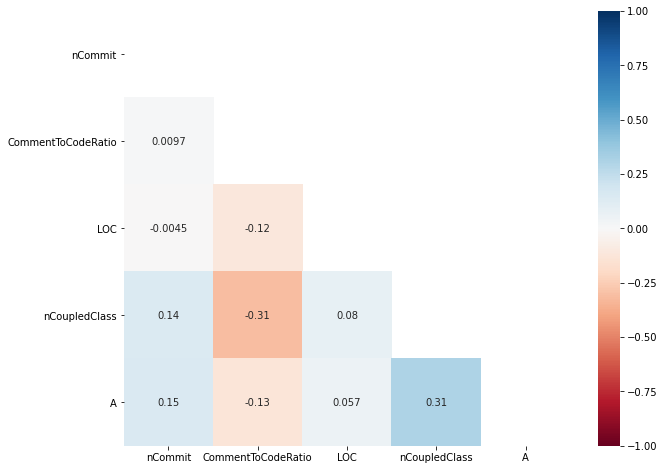

In [8]:

# Prepare a dataframe for AutoSpearman demo
X_AS_train = X_train.copy()

# Simulate a multicollinearity situation of AddedLOC, A, and B
X_AS_train['A'] = [2 * x_i + random.random() for x_i in X_AS_train['AddedLOC']]
X_AS_train['B'] = [3 * x_i + random.random() for x_i in X_AS_train['AddedLOC']]

AS_metrics = X_AS_train.columns
count = 1

# (Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test.
print('(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test')
while True:
    corrmat = X_AS_train.corr(method='spearman')
    top_corr_features = corrmat.index
    abs_corrmat = abs(corrmat)
    
    # identify correlated metrics with the correlation threshold of 0.7
    highly_correlated_metrics = ((corrmat > .7) | (corrmat < -.7)) & (corrmat != 1)
    n_correlated_metrics = np.sum(np.sum(highly_correlated_metrics))
    if n_correlated_metrics > 0:
        # find the strongest pair-wise correlation
        find_top_corr = pd.melt(abs_corrmat, ignore_index = False)
        find_top_corr.reset_index(inplace = True)
        find_top_corr = find_top_corr[find_top_corr['value'] != 1]
        top_corr_index = find_top_corr['value'].idxmax()
        top_corr_i = find_top_corr.loc[top_corr_index, :]

        # get the 2 correlated metrics with the strongest correlation
        correlated_metric_1 = top_corr_i[0]
        correlated_metric_2 = top_corr_i[1]
        print('Step', count,'comparing between', correlated_metric_1, 'and', correlated_metric_2)
        
        # compute their correlation with other metrics outside of the pair
        correlation_with_other_metrics_1 = np.mean(abs_corrmat[correlated_metric_1][[i for i in top_corr_features if i not in [correlated_metric_1, correlated_metric_2]]])
        correlation_with_other_metrics_2 = np.mean(abs_corrmat[correlated_metric_2][[i for i in top_corr_features if i not in [correlated_metric_1, correlated_metric_2]]])
        print('>', correlated_metric_1, 'has the average correlation of', np.round(correlation_with_other_metrics_1, 3), 'with other metrics')
        print('>', correlated_metric_2, 'has the average correlation of', np.round(correlation_with_other_metrics_2,3) , 'with other metrics')
        # select the metric that shares the least correlation outside of the pair and exclude the other
        if correlation_with_other_metrics_1 < correlation_with_other_metrics_2:
            exclude_metric = correlated_metric_2
        else:
            exclude_metric = correlated_metric_1
        print('>', 'Exclude',exclude_metric)
        count = count+1
        AS_metrics = list(set(AS_metrics) - set([exclude_metric]))
        X_AS_train = X_AS_train[AS_metrics]
    else:
        break

print('According to Part 1 of AutoSpearman,', AS_metrics,'are selected.')
generate_heatmap(X_AS_train)



*(Part 2) Automatically select non-correlated metrics based on a
Variance Inflation Factor analysis.* We first measure the magnitude of
multicollinearity of the remaining metrics ($M'$) from `Part 1` using
the Variance Inflation Factor analysis. We use a VIF
threshold value ($vif.t$) of 5 to identify the presence of
multicollinearity, as suggested by Fox {cite}`fox2015applied`.

To automatically remove correlated metrics from the Variance Inflation
Factor analysis, we identify the removed metric as the metric that has
the highest VIF score. We then exclude the removed
metric from the set of the remaining metrics ($M'$). We
apply the VIF analysis on the remaining metrics until none of the
remaining metrics have their VIF scores above or equal to the threshold
value. Finally,  produces a subset of non-correlated
metrics based on the Spearman rank correlation test and the VIF analysis
($M'$).

Similar to filter-based feature selection techniques, *Part 1*
of  measures the correlation of all metrics using the Spearman rank
correlation test regardless of model construction. Similar to
wrapper-based feature selection techniques, *Part 2* of  constructs
regression models to measure the magnitude of multicollinearity of
metrics. Thus, we consider  as a hybrid feature selection technique
(both filter-based and wrapper-based).


In [9]:

# Prepare a dataframe for VIF
X_AS_train = add_constant(X_AS_train)

selected_features = X_AS_train.columns
count = 1
# (Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis.
print('(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis')
while True:
    # Calculate VIF scores
    vif_scores = pd.DataFrame([variance_inflation_factor(X_AS_train.values, i) 
                   for i in range(X_AS_train.shape[1])], 
                  index=X_AS_train.columns)
    # Prepare a final dataframe of VIF scores
    vif_scores.reset_index(inplace = True)
    vif_scores.columns = ['Feature', 'VIFscore']
    vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
    vif_scores.sort_values(by = ['VIFscore'], ascending = False, inplace = True)
    
    # Find features that have their VIF scores of above 5.0
    filtered_vif_scores = vif_scores[vif_scores['VIFscore'] >= 5.0]
    
    # Terminate when there is no features with the VIF scores of above 5.0
    if len(filtered_vif_scores) == 0:
        break
        
    # exclude the metric with the highest VIF score
    metric_to_exclude = list(filtered_vif_scores['Feature'].head(1))[0]
    
    print('Step', count,'- exclude', str(metric_to_exclude))
    count = count + 1
        
    selected_features = list(set(selected_features) - set([metric_to_exclude]))
    
    X_AS_train = X_AS_train.loc[:, selected_features]

    
print('Finally, according to Part 2 of AutoSpearman,', AS_metrics,'are selected.')

(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis
Finally, according to Part 2 of AutoSpearman, ['nCommit', 'CommentToCodeRatio', 'LOC', 'nCoupledClass', 'A'] are selected.


To foster future replication, we provide a python implementation of AutoSpearman as a function below.

In [11]:
# Import for AutoSpearman
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np

'''
    For more detail and citation, please refer to:
    [1] Jirayus Jiarpakdee, Chakkrit Tantithamthavorn, Christoph Treude:
    The Impact of Automated Feature Selection Techniques on the Interpretation of Defect Models. Empir. Softw. Eng. 25(5): 3590-3638 (2020)

    [2] Jirayus Jiarpakdee, Chakkrit Tantithamthavorn, Christoph Treude:
    AutoSpearman: Automatically Mitigating Correlated Software Metrics for Interpreting Defect Models. ICSME 2018: 92-103
'''
def AutoSpearman(X_train, correlation_threshold = 0.7, correlation_method = 'spearman', VIF_threshold = 5):
    
    X_AS_train = X_train.copy()
    AS_metrics = X_AS_train.columns
    count = 1
    
    # (Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test.
    print('(Part 1) Automatically select non-correlated metrics based on a Spearman rank correlation test')
    while True:
        corrmat = X_AS_train.corr(method=correlation_method)
        top_corr_features = corrmat.index
        abs_corrmat = abs(corrmat)

        # identify correlated metrics with the correlation threshold of the threshold
        highly_correlated_metrics = ((corrmat > correlation_threshold) | (corrmat < -correlation_threshold)) & (corrmat != 1)
        n_correlated_metrics = np.sum(np.sum(highly_correlated_metrics))
        if n_correlated_metrics > 0:
            # find the strongest pair-wise correlation
            find_top_corr = pd.melt(abs_corrmat, ignore_index = False)
            find_top_corr.reset_index(inplace = True)
            find_top_corr = find_top_corr[find_top_corr['value'] != 1]
            top_corr_index = find_top_corr['value'].idxmax()
            top_corr_i = find_top_corr.loc[top_corr_index, :]

            # get the 2 correlated metrics with the strongest correlation
            correlated_metric_1 = top_corr_i[0]
            correlated_metric_2 = top_corr_i[1]
            print('> Step', count,'comparing between', correlated_metric_1, 'and', correlated_metric_2)

            # compute their correlation with other metrics outside of the pair
            correlation_with_other_metrics_1 = np.mean(abs_corrmat[correlated_metric_1][[i for i in top_corr_features if i not in [correlated_metric_1, correlated_metric_2]]])
            correlation_with_other_metrics_2 = np.mean(abs_corrmat[correlated_metric_2][[i for i in top_corr_features if i not in [correlated_metric_1, correlated_metric_2]]])
            print('>>', correlated_metric_1, 'has the average correlation of', np.round(correlation_with_other_metrics_1, 3), 'with other metrics')
            print('>>', correlated_metric_2, 'has the average correlation of', np.round(correlation_with_other_metrics_2,3) , 'with other metrics')
            # select the metric that shares the least correlation outside of the pair and exclude the other
            if correlation_with_other_metrics_1 < correlation_with_other_metrics_2:
                exclude_metric = correlated_metric_2
            else:
                exclude_metric = correlated_metric_1
            print('>>', 'Exclude',exclude_metric)
            count = count+1
            AS_metrics = list(set(AS_metrics) - set([exclude_metric]))
            X_AS_train = X_AS_train[AS_metrics]
        else:
            break

    print('According to Part 1 of AutoSpearman,', AS_metrics,'are selected.')

    # (Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis.
    print('(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis')
    
    # Prepare a dataframe for VIF
    X_AS_train = add_constant(X_AS_train)

    selected_features = X_AS_train.columns
    count = 1
    while True:
        # Calculate VIF scores
        vif_scores = pd.DataFrame([variance_inflation_factor(X_AS_train.values, i) 
                       for i in range(X_AS_train.shape[1])], 
                      index=X_AS_train.columns)
        # Prepare a final dataframe of VIF scores
        vif_scores.reset_index(inplace = True)
        vif_scores.columns = ['Feature', 'VIFscore']
        vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
        vif_scores.sort_values(by = ['VIFscore'], ascending = False, inplace = True)

        # Find features that have their VIF scores of above the threshold
        filtered_vif_scores = vif_scores[vif_scores['VIFscore'] >= VIF_threshold]

        # Terminate when there is no features with the VIF scores of above the threshold
        if len(filtered_vif_scores) == 0:
            break

        # exclude the metric with the highest VIF score
        metric_to_exclude = list(filtered_vif_scores['Feature'].head(1))[0]

        print('> Step', count,'- exclude', str(metric_to_exclude))
        count = count + 1

        selected_features = list(set(selected_features) - set([metric_to_exclude]))

        X_AS_train = X_AS_train.loc[:, selected_features]


    print('Finally, according to Part 2 of AutoSpearman,', AS_metrics,'are selected.')
    return(AS_metrics)

## Always handle class imbalance

### Class Rebalancing Techniques for Software Analytics

A plethora of class rebalancing techniques exist {cite}`he2009learning`,
e.g., (1) sampling methods for imbalanced learning, (2) cost-sensitive
methods for imbalanced learning, (3) kernel-based methods for imbalanced
learning, and (4) active learning for imbalanced learning. Since it is
impractical to study all of these techniques, we select a manageable set
of class rebalancing techniques for our study. As discussed by
He {cite}`he2009learning`, we start from the four families of imbalance
learning techniques. Based on a literature surveys by Hall *et al.* {cite}`hall2012systematic`,
Shihab {cite}`Shihab2012`, and Nam {cite}`nam2014survey`, we then select only the
family of sampling techniques for the context of defect prediction.

We first select the three commonly-used techniques (i.e., over-sampling,
under-sampling, and Default SMOTE {cite}`chawla2002smote`) that were
previously used in the literature {cite}`Kamei2007`{cite}`Khoshgoftaar2010`{cite}`Pelayo2007`{cite}`Seiffert2014`{cite}`tan2015online`{cite}`wang2013`{cite}`xia2015elblocker`{cite}`yang2016automated`{cite}`yang2017high`



```{figure} /defect-prediction/images/class-imbalance-overview.png
---
name: class-imbalance-overview
---
An illustrative overview of the 3 selected class rebalancing techniques.
```

Below, we provide a description and a discussion of the 3 selected class rebalancing techniques for our book with interactive python tutorials.


In [ ]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split
import numpy as np

# Import for Construct a black-box model (Regression and Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

train_dataset = pd.read_csv(("../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

# Compute class ratio
def get_class_ratio(input_data):
    n_data = len(input_data)
    n_defective = sum(input_data)
    n_clean = n_data - n_defective
    print('From the total of', n_data, 'files, there are:')
    print(n_defective, 'defective files', '('+str(np.round(n_defective*1.0/n_data*100, 2))+'%)')
    print(n_clean, 'clean files', '('+str(np.round(n_clean*1.0/n_data*100, 2))+'%)')
    

In [ ]:
# Find a class ratio of the original training dataset
get_class_ratio(y_train)

#### Over-Sampling Technique (OVER)

The over-sampling technique (a.k.a. up-sampling) randomly samples with
replacement (i.e., replicating) *the minority class* (e.g., defective
class) to be the same size as the majority class (e.g., clean class).
The advantage of an over-sampling technique is that it leads to no
information loss. Since oversampling simply adds replicated modules from
the original dataset, the disadvantage is that the training dataset ends
up with multiple redundant modules, leading to an overfitting. Thus,
when applying the over-sampling technique, the performance of with-in
defect prediction models is likely higher than the performance of
cross-project defect prediction models.


In [ ]:
# Import for the Over-Sampling technique (OVER)
from imblearn.over_sampling import RandomOverSampler

# Apply the Over-Sampling technique
oversample = RandomOverSampler(sampling_strategy='minority')
X_OVER_train, y_OVER_train = oversample.fit_resample(X_train, y_train)

# Find a class ratio of the over-sampled training dataset
get_class_ratio(y_OVER_train)

#### Under-Sampling Technique (UNDER)

The under-sampling technique (a.k.a. down-sampling) randomly samples
(i.e., reducing) *the majority class* (e.g., clean class) in order to
reduce the number of majority modules to be the same number as the
minority class (e.g., defective class). The advantage of an
under-sampling technique is that it reduces the size of the training
data when the original data is relatively large. However, the
disadvantage is that removing modules may cause the training data to
lose important information pertaining to the majority class.


In [ ]:
# Import for the Under-Sampling technique (UNDER)
from imblearn.under_sampling import RandomUnderSampler

# Apply the Under-Sampling technique
undersample = RandomUnderSampler(sampling_strategy='majority')
X_UNDER_train, y_UNDER_train = undersample.fit_resample(X_train, y_train)

# Find a class ratio of the under-sampled training dataset
get_class_ratio(y_UNDER_train)

#### Synthetic Minority Oversampling Technique (SMOTE)

The SMOTE technique {cite}`chawla2002smote` was proposed to combat the
disavantages of the simple over-sampling and under-sampling techniques.
The SMOTE technique creates artificial data based on the feature space
(rather than the data space) similarities from the minority modules. The
SMOTE technique starts with a set of minority modules (i.e., defective
modules). For each of the minority defective modules of the training
datasets, SMOTE performs the following steps:

1.  Calculate the $k$-nearest neighbors.

2.  Select $N$ majority clean modules based on the smallest magnitude of
    the euclidean distances that are obtained from the $k$-nearest
    neighbors.

Finally, SMOTE combines the synthetic oversampling of the minority
defective modules with the undersampling the majority clean modules.


In [ ]:
# Import for the Synthetic Minority Oversampling Technique (SMOTE)
from imblearn.over_sampling import SMOTE

# Apply the SMOTE technique
oversample_SMOTE = SMOTE(sampling_strategy='minority')
X_SMOTE_train, y_SMOTE_train = oversample_SMOTE.fit_resample(X_train, y_train)

# Find a class ratio of the SMOTE-ed training dataset
get_class_ratio(y_SMOTE_train)

```{note}
Parts of this chapter have been published by the following publications:\ 
[1] Chakkrit Tantithamthavorn, Ahmed E. Hassan, Kenichi Matsumoto: The Impact of Class Rebalancing Techniques on the Performance and Interpretation of Defect Prediction Models. IEEE Trans. Software Eng. 46(11): 1200-1219 (2020). \
[2] Jirayus Jiarpakdee, Chakkrit Tantithamthavorn, Ahmed E. Hassan: The Impact of Correlated Metrics on the Interpretation of Defect Models. IEEE Trans. Software Eng. 47(2): 320-331 (2021) https://doi.org/10.1109/TSE.2019.2891758."
```


## Suggested Readings

[1] Amritanshu Agrawal, Tim Menzies: Is "better data" better than "better data miners"?: on the benefits of tuning SMOTE for defect prediction. ICSE 2018: 1050-1061.

[2] Chakkrit Tantithamthavorn, Ahmed E. Hassan, Kenichi Matsumoto: The Impact of Class Rebalancing Techniques on the Performance and Interpretation of Defect Prediction Models. IEEE Trans. Software Eng. 46(11): 1200-1219 (2020).

[3] Jirayus Jiarpakdee, Chakkrit Tantithamthavorn, Ahmed E. Hassan: The Impact of Correlated Metrics on the Interpretation of Defect Models. IEEE Trans. Software Eng. 47(2): 320-331 (2021).

[4] Jirayus Jiarpakdee, Chakkrit Tantithamthavorn, Christoph Treude:
The Impact of Automated Feature Selection Techniques on the Interpretation of Defect Models. Empir. Softw. Eng. 25(5): 3590-3638 (2020).

[5] Jirayus Jiarpakdee, Chakkrit Tantithamthavorn, Christoph Treude:
AutoSpearman: Automatically Mitigating Correlated Software Metrics for Interpreting Defect Models. ICSME 2018: 92-103.
